In [1]:
import argparse
import tensorflow as tf
import numpy as np
from utils.classifier import Classifier
from utils import ind_process
from utils import hop_utils as hopu
from utils import sp_utils as spu
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 参数设置

In [2]:

def parse_args():
    '''
    Parses the arguments.
    '''
    parser = argparse.ArgumentParser(description="Run gate.")

    parser.add_argument('--dataset', nargs='?', default='cora',
                        help='Input dataset')

    parser.add_argument('--lr', type=float, default=0.0001,
                        help='Learning rate. Default is 0.001.')

    parser.add_argument('--n-epochs', default=200, type=int,
                        help='Number of epochs')

    parser.add_argument('--hidden_dims', type=list, nargs='+', default=[512, 128],
                        help='Number of dimensions.')

    parser.add_argument('--lambda_', default=1, type=float,
                        help='Parameter controlling the contribution of edge reconstruction in the loss function.')


    parser.add_argument('--K', default=3, type=int,
                        help='k-hops')    

    parser.add_argument('--beta', default=0.5, type=int,
                        help='beta') 
    parser.add_argument('--lambd1', default=10, type=int,
                        help='lambd1')    
    parser.add_argument('--lambd2', default=50, type=int,
                        help='lambd2')  
    parser.add_argument('--seed', default=10, type=int,
                        help='seed')        
      
    #return parser.parse_args()
    return parser.parse_args(args=[]) # jupyter 使用paraer的方法 必须(args=[])
#调用
args = parse_args()  
print(args)

Namespace(K=3, beta=0.5, dataset='cora', hidden_dims=[512, 128], lambd1=10, lambd2=50, lambda_=1, lr=0.0001, n_epochs=200, seed=10)


### 加载数据

In [3]:
#adj, X, Y, idx_train, idx_val, idx_test = process.load_data(args.dataset)
adj_train, adj, X_train, X, Y, idx_train, idx_val, idx_test,X_train_target = ind_process.load_data(args.dataset)

In [4]:
#WATCH 
print(X.shape,Y.shape,type(X),type(Y))
print(adj_train.shape,adj.shape)
print(idx_train)
print(idx_val)
print(len(idx_test))

(2708, 1433) (2708, 7) <class 'numpy.matrix'> <class 'numpy.ndarray'>
(1208, 1208) (2708, 2708)
range(0, 140)
range(140, 640)
1000


In [5]:

adj_tf, row, col = ind_process.prepare_graph_data(adj_train)


In [6]:
# hidder layer
feature_dim = X.shape[1]
args.hidden_dims = [feature_dim] + args.hidden_dims
print(args.hidden_dims)

[1433, 512, 128]


### MODEL

In [7]:
class GATRE():
    def __init__(self, args,A):
        tf.reset_default_graph()
        tf.set_random_seed(args.seed)
        np.random.seed(args.seed)
        
        
        self.args = args
        self.lambda_ = args.lambda_
        self.n_layers = len(args.hidden_dims) -1

        self.build_placeholders()
        self.W, self.v = self.define_weights(args.hidden_dims)
        self.C = {}

        hops = hopu.get_hops(A, args.K)
        
        scale_terms = {h if h != -1 else max(hops.keys()) + 1:
                           hops[h].sum(1).A1 if h != -1 else hops[1].shape[0] - hops[h].sum(1).A1
                       for h in hops}
        

        self.__dataset_generator(hops, scale_terms)

        
        
        self.build_model()

        self.build_loss()
        
    

    def build_placeholders(self):
        self.A = tf.sparse_placeholder(dtype=tf.float32)
        self.X = tf.placeholder(dtype=tf.float32)
        self.row = tf.placeholder(tf.int64)
        self.col = tf.placeholder(tf.int64)  

    def define_weights(self, hidden_dims):
        W = {}
        for i in range(self.n_layers):
            W[i] = tf.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        Ws_att = {}
        for i in range(self.n_layers):
            v = {}
            v[0] = tf.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
            v[1] = tf.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))
            Ws_att[i] = v

        return W, Ws_att
    def build_model(self):
        # Encoder
        H = self.X
        for layer_i in range(self.n_layers):
            H = self.__encoder(self.A, H, layer_i)

        # Final node representations
        self.H = H

        # Decoder
        for layer_i in range(self.n_layers - 1, -1, -1):
            H = self.__decoder(H, layer_i)
        #reconstruct X
        self.X_ = H
   
    def build_loss(self):
        self.__build_tri_loss()

        self.features_loss = tf.sqrt(tf.reduce_sum(tf.reduce_sum(tf.pow(self.X - self.X_, 2),axis=-1)))
                              
        self.S_emb = tf.nn.embedding_lookup(self.H, self.row)
        self.R_emb = tf.nn.embedding_lookup(self.H, self.col)

        sim = self.__sim(self.S_emb,self.R_emb)

        structure_loss = -tf.log(sim)/self.args.lambd1  

        self.structure_loss = tf.reduce_sum(structure_loss)

        self.loss = self.features_loss +  self.loss_tri + self.structure_loss  
    def __build_tri_loss(self):
        hop_pos = tf.stack([self.triplets[:, 0], self.triplets[:, 1]], 1)
        hop_neg = tf.stack([self.triplets[:, 0], self.triplets[:, 2]], 1)
        anchor = tf.gather(self.H,hop_pos[:,0])
        pos = tf.gather(self.H,hop_pos[:,1])
        neg = tf.gather(self.H,hop_neg[:,1])
        
        self.loss_p = tf.reduce_sum(pos * anchor, axis=-1)
        self.loss_n = tf.reduce_sum(neg * anchor, axis=-1)
        
        sim1 = self.__sim(pos,anchor)
        sim2 = self.__sim(neg,anchor)
        
        loss_0 = -self.loss_p+self.loss_n+self.args.beta
        loss_0 = tf.gather(loss_0,tf.where(tf.greater(loss_0,0)))
        loss_tri = loss_0

        self.loss_tri = tf.reduce_sum(loss_tri)/self.args.lambd2 
        
    def __sim(self,n1,n2):
        fz = tf.reduce_sum(n1 * n2,axis=-1)
        fm1 = tf.sqrt(tf.reduce_sum(tf.pow(n1,2),axis=-1))
        fm2 = tf.sqrt(tf.reduce_sum(tf.pow(n2,2),axis=-1))
        fm = fm1*fm2
        return fz/fm
    def __dataset_generator(self, hops, scale_terms):

        def gen():
            while True:
                yield hopu.to_triplets(hopu.sample_all_hops(hops), scale_terms)

        dataset = tf.data.Dataset.from_generator(gen, (tf.int32, tf.float32), ([None, 3], [None]))
        self.triplets, self.scale_terms = dataset.prefetch(1).make_one_shot_iterator().get_next()
        
    def train(self, A,X,row,col,gpu= True):
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = tf.Session(config=config)
        
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.args.lr).minimize(self.loss)

        self.session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
  
        for epoch in range(self.args.n_epochs):
            loss,_,l_x,l_s,l_t = self.session.run([self.loss,self.train_op,self.features_loss,\
                                          self.structure_loss,self.loss_tri],
                                             feed_dict={self.A: A,
                                                        self.X: X,
                                                        self.row: row,
                                                        self.col: col})

            print("Epoch: %s, Loss: %.2f, X_Loss:%.2f, S_Loss:%.2f, T_Loss:%.2f" % (epoch, loss,l_x,l_s,l_t))
        return loss,self.session
        

    def infer(self, A,X,row,col):
        H, C = self.session.run([self.H, self.C],
                           feed_dict={self.A: A,
                                      self.X: X,
                                      self.row: row,
                                      self.col: col})
        return H, spu.conver_sparse_tf2np(C)
    def __encoder(self, A, H, layer_i):

        H = tf.matmul(H, self.W[layer_i])
        self.C[layer_i] = self.graph_attention_layer(A, H, self.v[layer_i], layer_i)
        return tf.sparse_tensor_dense_matmul(self.C[layer_i], H)

    def __decoder(self, H, layer_i):
        #'''
        H = tf.matmul(H, self.W[layer_i], transpose_b=True)
        return tf.sparse_tensor_dense_matmul(self.C[layer_i], H)     

    def graph_attention_layer(self, A, M, v, layer):
        with tf.variable_scope("layer_%s"% layer):
            f1 = tf.matmul(M, v[0])
            f1 = A * f1
            f2 = tf.matmul(M, v[1])
            f2 = A * tf.transpose(f2, [1, 0])
            logits = tf.sparse_add(f1, f2)

            unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                         values=tf.nn.sigmoid(logits.values),
                                         dense_shape=logits.dense_shape)
            attentions = tf.sparse_softmax(unnormalized_attentions)

            attentions = tf.SparseTensor(indices=attentions.indices,
                                         values=attentions.values,
                                         dense_shape=attentions.dense_shape)

            return attentions    
        

### Train

In [8]:
model = GATRE(args,adj_train)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [9]:
loss,sess = model.train(adj_tf,X_train_target,row,col,gpu= True)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Epoch: 0, Loss: 140.10, X_Loss:98.91, S_Loss:15.92, T_Loss:25.26
Epoch: 1, Loss: 138.21, X_Loss:98.76, S_Loss:14.71, T_Loss:24.74
Epoch: 2, Loss: 136.65, X_Loss:98.59, S_Loss:13.65, T_Loss:24.42
Epoch: 3, Loss: 135.09, X_Loss:98.38, S_Loss:12.72, T_Loss:23.98
Epoch: 4, Loss: 133.74, X_Loss:98.14, S_Loss:11.93, T_Loss:23.67
Epoch: 5, Loss: 132.72, X_Loss:97.86, S_Loss:11.24, T_Loss:23.62
Epoch: 6, Loss: 131.28, X_Loss:97.54, S_Loss:10.64, T_Loss:23.10
Epoch: 7, Loss: 129.95, X_Loss:97.18, S_Loss:10.13, T_Loss:22.65
Epoch: 8, Loss: 128.75, X_Loss:96.79, S_Loss:9.68, T_Loss:22.28
Epoch: 9, Loss: 128.23, X_Loss:96.37, S_Loss:9.29, T_Loss:22.57
Epoch: 10, Loss: 126.63, X_Loss:95.92, S_Loss:8.96, T_Loss:21.76
Epoch: 11, Loss: 125.61, X_Loss:95.46, S_Loss:8.67, T_Loss:21.49
Epoch: 12, Loss: 124.95, X_Loss:94.98, S_Loss:8.41, T

Epoch: 118, Loss: 98.15, X_Loss:77.38, S_Loss:6.42, T_Loss:14.36
Epoch: 119, Loss: 98.02, X_Loss:77.32, S_Loss:6.42, T_Loss:14.29
Epoch: 120, Loss: 97.73, X_Loss:77.25, S_Loss:6.43, T_Loss:14.05
Epoch: 121, Loss: 97.84, X_Loss:77.19, S_Loss:6.43, T_Loss:14.22
Epoch: 122, Loss: 97.72, X_Loss:77.12, S_Loss:6.44, T_Loss:14.16
Epoch: 123, Loss: 97.56, X_Loss:77.06, S_Loss:6.44, T_Loss:14.06
Epoch: 124, Loss: 96.83, X_Loss:77.00, S_Loss:6.44, T_Loss:13.39
Epoch: 125, Loss: 97.00, X_Loss:76.94, S_Loss:6.45, T_Loss:13.62
Epoch: 126, Loss: 96.61, X_Loss:76.87, S_Loss:6.46, T_Loss:13.28
Epoch: 127, Loss: 97.10, X_Loss:76.81, S_Loss:6.46, T_Loss:13.83
Epoch: 128, Loss: 97.61, X_Loss:76.75, S_Loss:6.47, T_Loss:14.40
Epoch: 129, Loss: 96.94, X_Loss:76.68, S_Loss:6.48, T_Loss:13.77
Epoch: 130, Loss: 96.75, X_Loss:76.62, S_Loss:6.50, T_Loss:13.63
Epoch: 131, Loss: 96.79, X_Loss:76.56, S_Loss:6.51, T_Loss:13.72
Epoch: 132, Loss: 96.85, X_Loss:76.49, S_Loss:6.52, T_Loss:13.83
Epoch: 133, Loss: 96.61, 

In [10]:

adj_tf, row, col = ind_process.prepare_graph_data(adj)
embeddings, attentions = model.infer(adj_tf,X,row,col)
# Evaluate the quality of embeddings
classifier = Classifier(embeddings,Y)

In [16]:
f1_micro, f1_macro = classifier.cross_validation_classify(n_repeat=10, norm=True)
print('Micro_F1: {:.4f}, Macro_f1: {:.4f}'.format(f1_micro, f1_macro))

Micro_F1: 0.8367, Macro_f1: 0.8234


In [12]:
auc_score,_= classifier.auc_ap_scores(adj)
print(auc_score)

0.9978527118720709


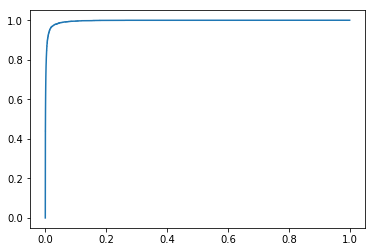

In [13]:
fpr, tpr, thresholds = classifier._roc_curve(adj)

plt.plot(fpr,tpr)
plt.show()

In [14]:
#print(embeddings.shape)
from sklearn.manifold import TSNE
tsne =  TSNE(n_components=2, learning_rate=100)
data = tsne.fit_transform(embeddings)

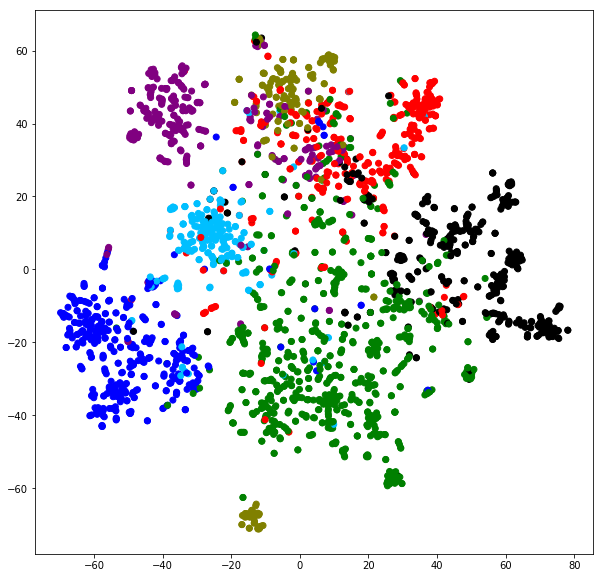

In [15]:
color=[]
C = np.where(Y==1)[1]
for i in range(len(C)):
    
    if C[i] == 0:
        color.append('red')
    if C[i] == 1:
        color.append('deepskyblue')
    if C[i] == 2:
            color.append('blue')
    if C[i] == 3:
            color.append('green')
    if C[i] == 4:
            color.append('black')
    if C[i] == 5:
            color.append('purple')
    if C[i] == 6:
            color.append('olive')        
fig=plt.figure(figsize=(10,10),facecolor='white')
plt.scatter(data[:,0], data[:,1], c=color)
plt.show()    

